### Instructions to run:

To run this notebook : 
Download Training Dataset from https://github.com/abachaa/VQA-Med-2019 and place the notebook in the inner directory containing the file 'All_QA_Pairs_train.txt'

Download Clinical Embeddings named 'PubMed-and-PMC-w2v.bin' (3GB+) from http://evexdb.org/pmresources/vec-space-models/ 
<br>or<br> Use only the required embeddings for our dataset found here https://github.com/ahsanabbas123/VQA-Med/blob/master/embeddings.csv 


In [ ]:
!pip install wordcloud
!pip install seaborn
!pip install gensim

In [1]:
import pandas as pd
import numpy as np
import re
import time

import math 
from sklearn.metrics.pairwise import cosine_similarity as cs

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

In [ ]:
%matplotlib inline

## Loading and preprocessing dataset

In [68]:
# loading all QA pairs data
df_all = pd.read_csv('All_QA_Pairs_train.txt', sep="|", header=None)
df_all.Name = 'all'

# loading category wise data
df_modality = pd.read_csv('QAPairsByCategory/C1_Modality_train.txt', sep="|", header=None)
df_modality.Name = 'modality'
df_plane = pd.read_csv('QAPairsByCategory/C2_Plane_train.txt', sep="|", header=None)
df_plane.Name = 'plane'
df_organ = pd.read_csv('QAPairsByCategory/C3_Organ_train.txt', sep="|", header=None)
df_organ.Name = 'organ'
df_abnormality = pd.read_csv('QAPairsByCategory/C4_Abnormality_train.txt', sep="|", header=None)
df_abnormality.Name = 'abnormality'

# setting column names
categories = (df_all, df_modality, df_plane, df_organ, df_abnormality)
for d in categories:
    d.columns = ['ID','Q','A']

In [69]:
# preprocessing

# dictionary of replaceable words
replace_dict = {"magnetic resonance imaging":"mr",
                "mri scan":'mr',
                "mri":'mr',
                "t1w":'t1',
                "t2w":'t2',
                "weighted":"",
#                 " w ": "",
#                 " s" : "",
                "shows": "show",
                "reveal":"show",
                "demonstrated":"demonstrate",
                "demonstrate":"show",
                "ct scan":"ct",
                "mr":"mri",
#                 "devics" : "devic's",
                "gradientgrempgrswanswi":"",
#                 "t2\*" : "t2" ,
                # misspellings
                "unilteral":"unilateral",
                "appendigitis":"appendicitis",
                "congital":"congenital",
                "cytsic":"cystic",
                "boipsy":"biopsy",
                "dislocaton":"dislocation",
                "julgular":"jugular",
                "chrohn": "crohn",
                "o’donahue":"odonahue" #handing apostrophe
                }

# removing punctuations, extra white spaces etc
def _parse_sentence(s):
#     TODO : convert to regex expression
    s = s.strip() 
    s = s.replace('.',"  ")
    s = s.replace(',',"  ")
    s = s.replace('!',"  ")
    s = s.replace('-',"  ")
    s = s.replace('"',"  ")
    s = s.replace("'","  ")
#     s = s.replace("’s",' ')
    s = s.replace("?","  ")
    s = s.replace(':',"  ")
    s = s.replace("&", "and")
    s = s.replace("(","  ")
    s = s.replace(")","  ")
    s = s.replace('\\', "  ")
    s = s.replace('/', "  ")
    s = s.replace("'s ", "  ")
    s = re.sub("\s\s+", " ", s)
    s = s.replace("-"," ")
    s = s.lower()
    s = s.strip()
    s = s.split(' ')
    return s
    
def _parse_series(df):
    df['Q_parsed'] = [_parse_sentence(s) for s in df['Q']]
    df['A_parsed'] = [_parse_sentence(s) for s in df['A']]
    
    
# parsing all dataframes
for cat in categories:
    _parse_series(cat)

# replacing words
for d in categories:
    d.replace(to_replace=replace_dict, inplace=True, regex=True)
    
print (_parse_sentence("/wgac t's() - ew &- ! "))

['wgac', 't', 's', 'ew', 'and']


## Creating vocab and encoding Q/A words to numbers

In [70]:
# creating vocabulary and (id to word and vice-versa) dictionaries

BUFFER_TOKENS = ['<NULL>', '<START>', '<END>', '<UNK>']

# list of all words including repeats 
list_of_all_words = []
for i in range(0, len(df_all)):
    list_of_all_words+=(df_all['Q_parsed'].iloc[i])
    list_of_all_words+=(df_all['A_parsed'].iloc[i])
    
# selecting all unique words to form vocab
mostcommon = FreqDist(list_of_all_words).most_common(5000) 
vocab = [i[0] for i in mostcommon]
print (len(mostcommon)) # only ~2088 unique words in the text though


# vocab dicts
word_to_idx = {}
idx_to_word = {}

# populating vocab dicts
for i in range(0, len(BUFFER_TOKENS)):
    word_to_idx[BUFFER_TOKENS[i]] = i
    idx_to_word[int(i)] = BUFFER_TOKENS[i]
    
for i in range(len(vocab)):
    word_to_idx[vocab[i]] = len(BUFFER_TOKENS) + i
    idx_to_word[int(i + len(BUFFER_TOKENS))] = vocab[i]

# print(word_to_idx)
# print(idx_to_word)

# encoding sentences (a list of words) to a vector of numbers using vocab dicts
PADDING_LEN = 22

def _encode_sentence(s):
    UNK_ID = BUFFER_TOKENS.index('<UNK>')
    NULL_ID = BUFFER_TOKENS.index('<NULL>')
    END_ID = BUFFER_TOKENS.index('<END>')
    START_ID = BUFFER_TOKENS.index('<START>')
    s_encoded = [word_to_idx.get(w,UNK_ID) for w in s]
    s_encoded = [START_ID] + s_encoded
    s_encoded += [END_ID]
    s_encoded += [NULL_ID] * (PADDING_LEN - 1 - len(s_encoded))
    return s_encoded  

# testing fn
print (_encode_sentence(['what', 'is', 'the', 'modality', 'mri']))

# encoding parsed q and a to numeric arrays
for cat in categories:
    cat['Q_encoded'] = [_encode_sentence(q) for q in cat['Q_parsed']]  
    cat['A_encoded'] = [_encode_sentence(a) for a in cat['A_parsed']]

2087
[1, 5, 4, 8, 26, 13, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Features and Illutsrations of Q/A data 
### Visit https://observablehq.com/@ahsanabbas123/zoomable-sunburst for category wise frequent answers

In [71]:
# checking maximum length of q/a sentence in dataset
ans_l = 0
ques_l = 0

def longest_length_sentence_in_series(df):    
    m = 0
    for s in df:
        if (len(s) > m):
            m = len(s)
    return m

print ("Longest answer is {} words".format(longest_length_sentence_in_series(df_all['A_parsed'])))
print ("Longest question is {} words".format(longest_length_sentence_in_series(df_all['Q_parsed'])))

Longest answer is 21 words
Longest question is 11 words


In [39]:
# plot the common words and frequency in answers

# can be changed to show for questions by changing df['A_parsed'] to df['Q_parsed']
# TODO : add argument to select whether to plot in ans, ques or both 

# function to plot frequent words
def make_freq_words_plot(df):
    all_answer_words = []
    for ans in df['A_parsed']:
        for word in ans:
            all_answer_words.append(word)

    frequent_words = FreqDist(all_answer_words).most_common(25)

    words_freq = pd.DataFrame()
    words_freq['word'] = [(i[0]) for i in frequent_words]
    words_freq['freq'] = [int(i[1]) for i in frequent_words]

    # words_freq
    dims=(12,4)
    fig, ax = plt.subplots(figsize=dims)
    ax = sns.barplot(ax = ax, x="word", y="freq", data=words_freq)
    ax.set_title(df.Name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()

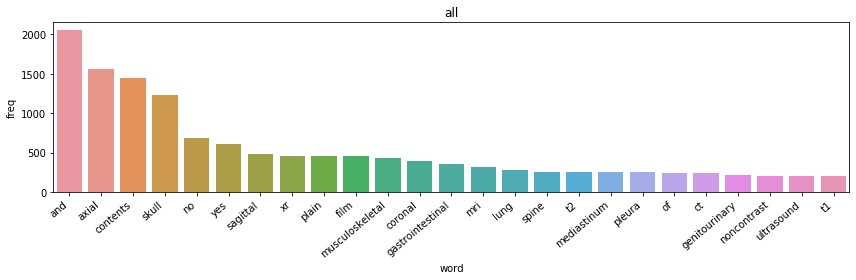

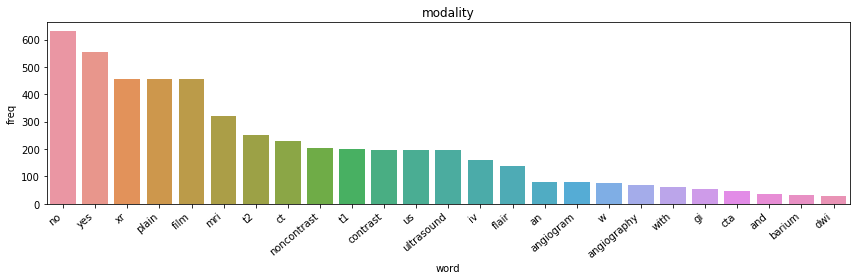

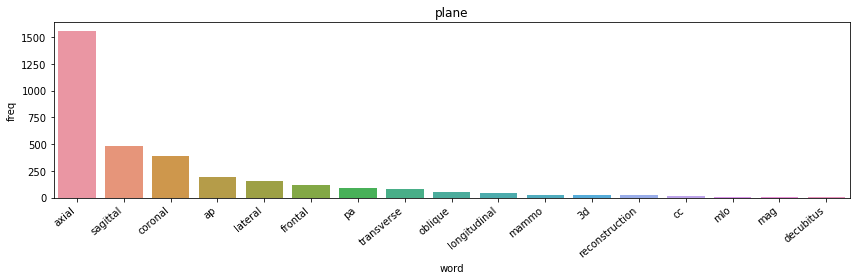

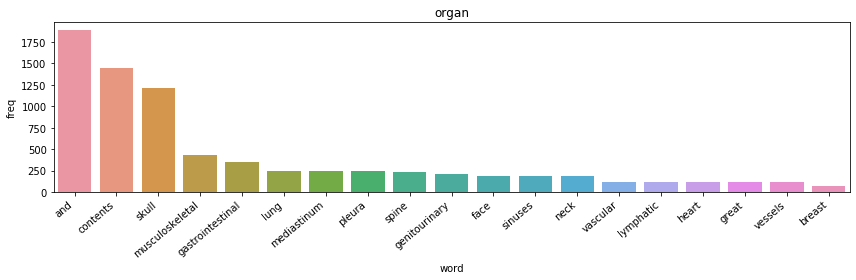

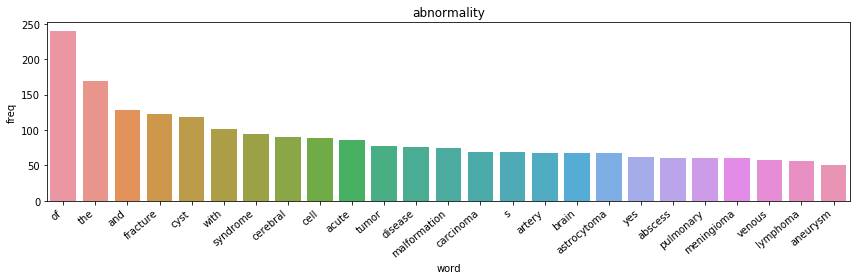

In [40]:
# plotting for different categories

for cat in categories:
    make_freq_words_plot(cat)

In [515]:
# average length of q/a in various categories

def get_average_length(df):
    tot_words = 0
    for ans in df:
        tot_words += len(ans)

    average = tot_words / len(df)

    return (average)

for cat in categories:
    print ("The average length of questions in category {} is".format(cat.Name), get_average_length(cat['Q_parsed']))
    print ("The average length of answers in category {} is ".format(cat.Name), get_average_length(cat['A_parsed']))
    print ("\n")


The average length of questions in category all is 7.916901188242652
The average length of answers in category all is  2.1884771732332706


The average length of questions in category modality is 7.7853125
The average length of answers in category modality is  1.86625


The average length of questions in category plane is 7.21
The average length of answers in category plane is  1.014375


The average length of questions in category organ is 8.4925
The average length of answers in category organ is  2.4303125


The average length of questions in category abnormality is 8.180451127819548
The average length of answers in category abnormality is  3.4461152882205512




In [583]:
# # category wise data describe 

# for d in categories:
#     print ("\nquestions in {}".format(d.Name))
#     print (d['Q_parsed'].describe())
#     print ("\nanswers in {}".format(d.Name))
#     print (d['A_parsed'].describe())
# #     print ("\n")
# #     print ("\n")

In [519]:
# all unique unparsed q/a 
def showUnique(df, Name):
    print ("Printing unique keywords for category {}".format(Name))
    print ("Number of unique answers are {}\n".format(len(df.unique())))
    print (df.unique())
    print ("\n")

for cat in categories:
    showUnique(cat['A'], cat.Name) # change to Q to see unique questions

Printing unique keywords for category all
Number of unique answers are 1551

['cta - ct angiography' 'no' 'us - ultrasound' ...
 'septic arthritis with lt hip effusion'
 'juvenile nasopharyngeal angiofibroma'
 'ossification of stylohyoid ligament']


Printing unique keywords for category modality
Number of unique answers are 44

['cta - ct angiography' 'no' 'us - ultrasound' 'xr - plain film'
 'noncontrast' 'yes' 't2' 'ct w/contrast (iv)' 'mri - flair' 'mammograph'
 'ct with iv contrast' 'gi and iv' 't1' 'mri - t2 weighted'
 'mri - t1 w/gadolinium' 'contrast' 'iv' 'an - angiogram'
 'mria - mri angiography/venography' 'nm - nuclear medicine'
 'mri - dwi diffusion weighted' 'ct - gi & iv contrast' 'ct noncontrast'
 'mri - other pulse seq.' 'ct with gi and iv contrast' 'flair'
 'mri - t1 w/gd (fat suppressed)' 'ugi - upper gi'
 'mri - adc map (app diff coeff)' 'bas - barium swallow'
 'pet - positron emission' 'mri - pdw proton density'
 'mri - t1 - noncontrast' 'be - barium enema' 'us-d -

[('is', 11002), ('what', 9735), ('this', 7406), ('image', 5543), ('in', 5482), ('the', 5364), ('plane', 3200), ('organ', 2770), ('mri', 2212), ('system', 2055), ('ct', 1837), ('abnormality', 1525), ('of', 1434), ('taken', 1269), ('was', 1262), ('which', 1190), ('seen', 1122), ('modality', 1085), ('a', 1051), ('shown', 934), ('imaging', 882), ('used', 810), ('abnormal', 798), ('most', 772), ('alarming', 772), ('about', 772), ('imaged', 743), ('primary', 736), ('to', 601), ('contrast', 573), ('x', 539), ('ray', 539), ('being', 456), ('here', 451), ('or', 445), ('part', 430), ('body', 430), ('with', 419), ('t1', 412), ('take', 404), ('type', 403), ('noncontrast', 394), ('t2', 389), ('show', 370), ('primarily', 292), ('evaluated', 288), ('flair', 258), ('displayed', 249), ('captured', 247), ('ultrasound', 244)]


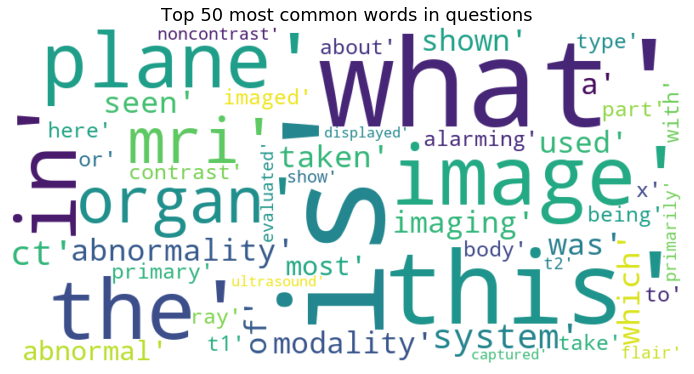

In [43]:
# function to generate wordclouds

def generate_wordcloud(words, topn):
    mostcommon = FreqDist(words).most_common(topn)
    print (mostcommon)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(str(mostcommon))
    fig = plt.figure(figsize=(15,5), facecolor='white')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title('Top {} most common words in questions'.format(topn), fontsize = 18)

    plt.tight_layout(pad=0)
    plt.show()

all_question_words = []
for ans in df_all['Q_parsed']:
    for word in ans:
        all_question_words.append(word)
        
all_questions = [val for val in df_all['Q']]
all_modality = [val for val in df_modality['Q']]
all_plane = [val for val in df_plane['Q']]
all_organ = [val for val in df_organ['Q']]
all_abnormality = [val for val in df_abnormality['Q']]


generate_wordcloud(all_question_words, 50) # replace to generate for different categories

# Clinical Word Embeddings 

In [72]:
# # Uncomment if using whole embeddings and change path to the coorect file
# # loading clinical embeddings trained on PMC and PubMed Articles
# from gensim.models.keyedvectors import KeyedVectors

# model = KeyedVectors.load_word2vec_format('..\..\..\..\Downloads\PubMed-and-PMC-w2v.bin', binary=True)

### Testing model embeddings

Comment-out this and next 2 sections if using only 'embeddings.csv'

In [212]:
print (model.similarity('skull', 'welcome'))
print (model.similarity('modality', 'mri'))
print (model.similarity('infarction', 'myocardial'))
print (model.similarity('ischemic', 'stroke'))
print (model.similarity('medicine', 'pediatrics'))
print (model.similarity('abnormality', 'abnormal'))
print (model.similarity('fracture', 'osteoporosis'))
print (model.similarity('crohn', 'ileum'))
print (model.similarity('cannula', 'show'))
print (model.similarity('cannula', 'insert'))
print (model.similarity('artery', 'mri'))
print (model.similarity('noncontrast', 'contrast'))
print (model.similarity('noncontrast', 'contrast'))
print (model.similarity('benign', 'tumor'))
print (model.similarity('benign', 'tumor'))

0.020767003
0.37854868
0.7304951
0.7451581
0.77312154
0.7023732
0.57813686
0.2567314
-0.059633907
0.3094061
0.094664395
0.12646183
0.12646183
0.3783493
0.3783493


### Testing Embedding for similar words

In [134]:
print (model.similar_by_vector(model['plane'], topn=10))

[('plane', 0.9999999403953552), ('planes', 0.8751378059387207), ('perpendicular', 0.8055003881454468), ('z-axis', 0.7746583223342896), ('tilted', 0.7433577179908752), ('z-direction', 0.7369154095649719), ('xy-plane', 0.7321602702140808), ('x-y', 0.7298304438591003), ('axial', 0.7263980507850647), ('bisector', 0.7119565010070801)]


In [152]:
print (model.similar_by_vector(model['thrombosis'], topn=15, restrict_vocab=10000))

[('thrombosis', 1.0), ('thromboembolism', 0.7585775852203369), ('embolism', 0.694661021232605), ('venous', 0.6865391731262207), ('thrombotic', 0.6689872741699219), ('embolization', 0.6529227495193481), ('thrombus', 0.6486895084381104), ('vein', 0.643187403678894), ('occlusion', 0.6221002340316772), ('veins', 0.610260546207428), ('portal', 0.5814192295074463), ('artery', 0.57244473695755), ('arteriovenous', 0.5676113963127136), ('hemorrhage', 0.5650493502616882), ('aneurysm', 0.5622318983078003)]


In [153]:
print (model.similar_by_vector(model['microbiome'], topn=15, restrict_vocab=10000))

[('microbiota', 0.8641736507415771), ('flora', 0.7380523681640625), ('gut', 0.639879047870636), ('microbial', 0.6066663265228271), ('microbes', 0.5752256512641907), ('ecology', 0.5552197694778442), ('proteome', 0.5068845748901367), ('colonization', 0.4949248135089874), ('organism', 0.4795113205909729), ('communities', 0.47855135798454285), ('pathogen', 0.4705943167209625), ('ecosystem', 0.4677930176258087), ('organisms', 0.4672757089138031), ('pathogens', 0.46434545516967773), ('physiology', 0.46367761492729187)]


In [154]:
print (model.similar_by_vector(model['gut'], topn=15, restrict_vocab=10000))

[('gut', 0.9999999403953552), ('intestinal', 0.8036315441131592), ('microbiota', 0.7318477630615234), ('flora', 0.6477329730987549), ('intestine', 0.6388239860534668), ('colonic', 0.6239259243011475), ('mucosal', 0.6233099699020386), ('digestive', 0.5974258184432983), ('mucosa', 0.5844686031341553), ('stomach', 0.5814363956451416), ('microbes', 0.5781675577163696), ('colonization', 0.5470613241195679), ('epithelia', 0.546765923500061), ('mucus', 0.536169171333313), ('enteric', 0.5360227823257446)]


In [158]:
print (model.similar_by_vector(model['sterile'], topn=15, restrict_vocab=10000))

[('sterile', 1.0), ('distilled', 0.6903765797615051), ('tubes', 0.6876124143600464), ('suspended', 0.642582893371582), ('ml', 0.6390014886856079), ('mL', 0.6243720054626465), ('saline', 0.6164121031761169), ('rinsed', 0.6152230501174927), ('homogenized', 0.6128495931625366), ('suspension', 0.6126868724822998), ('fresh', 0.5971494913101196), ('clean', 0.5827956199645996), ('plastic', 0.5809311866760254), ('resuspended', 0.5630724430084229), ('dried', 0.5620747804641724)]


In [160]:
print (model.similar_by_vector(model['troponin'], topn=15))

[('troponin', 1.0), ('Troponin', 0.9045851230621338), ('troponins', 0.8627941012382507), ('cTnI', 0.8522030711174011), ('TnI', 0.8445532321929932), ('cTnT', 0.8396105170249939), ('cTn', 0.8107367157936096), ('TnT', 0.8103085160255432), ('troponin-I', 0.7871407270431519), ('troponin-T', 0.77200847864151), ('I(129-166)', 0.7224023938179016), ('CTnI', 0.7200860977172852), ('CK-MB', 0.7112824320793152), ('cTn-I', 0.7008760571479797), ('CKMB', 0.6991267800331116)]


In [167]:
print (model.similar_by_vector(model['arrythmia'], topn=20))

[('arrythmia', 1.0), ('arrythmias', 0.8684935569763184), ('arrhythmia', 0.846410870552063), ('dysrhythmias', 0.8391797542572021), ('arrhythmias', 0.8189032673835754), ('bradyarrhythmia', 0.8102084398269653), ('tachyarrythmias', 0.7996642589569092), ('bradyarrhythmias', 0.7972347736358643), ('dysrhythmia', 0.7940508723258972), ('dysrrhythmias', 0.7896811962127686), ('arrhytmias', 0.7855595350265503), ('tachysystolic', 0.7819957733154297), ('tachy-arrhythmias', 0.7768837213516235), ('tachycardial', 0.7743464708328247), ('tachyarrythmia', 0.7709850668907166), ('arrhytmia', 0.7688525915145874), ('Cerebrogenic', 0.7556618452072144), ('bradydysrhythmias', 0.7556543350219727), ('dysrrhythmia', 0.7553064227104187), ('disrhythmias', 0.7552541494369507)]


In [168]:
print (model.similar_by_vector(model['failure'], topn=15, restrict_vocab=10000))

[('failure', 1.0), ('congestive', 0.7064043283462524), ('CHF', 0.661030650138855), ('end-stage', 0.6437994837760925), ('insufficiency', 0.6182920932769775), ('heart', 0.5775583386421204), ('dysfunction', 0.561992883682251), ('failing', 0.561861515045166), ('HF', 0.5349461436271667), ('worsening', 0.5270103216171265), ('transplant', 0.5242524743080139), ('allograft', 0.5152289867401123), ('ESRD', 0.5099036693572998), ('rejection', 0.5075160264968872), ('arrhythmia', 0.49884355068206787)]


In [169]:
print (model.similar_by_vector(model['retina'], topn=15, restrict_vocab=10000))

[('retina', 1.0), ('retinal', 0.7722614407539368), ('photoreceptor', 0.7210143804550171), ('cornea', 0.6885852813720703), ('RPE', 0.671828031539917), ('optic', 0.6386959552764893), ('pigment', 0.6011422276496887), ('lens', 0.5960385203361511), ('ganglion', 0.5775911808013916), ('eye', 0.5725092887878418), ('cone', 0.559904932975769), ('ciliary', 0.5503270626068115), ('epithelium', 0.5471885204315186), ('eyes', 0.5435465574264526), ('chick', 0.5402145385742188)]


In [170]:
print (model.similar_by_vector(model['gastrointenstinal'], topn=15, restrict_vocab=10000))

[('gastrointestinal', 0.5590817332267761), ('bleeding', 0.4671619236469269), ('life-threatening', 0.4509679675102234), ('GI', 0.4447898268699646), ('ulceration', 0.4140136241912842), ('oedema', 0.4099697470664978), ('stomach', 0.40547609329223633), ('tract', 0.4015015959739685), ('Severe', 0.40031957626342773), ('serious', 0.39502203464508057), ('severe', 0.3906952738761902), ('perforation', 0.3874979317188263), ('obstruction', 0.38536015152931213), ('jaundice', 0.3850302994251251), ('diarrhea', 0.3847503364086151)]


In [172]:
print (model.similar_by_vector(model['perforation'], topn=15, restrict_vocab=10000))

[('perforation', 1.0), ('fistula', 0.7528733611106873), ('bleeding', 0.6987498998641968), ('obstruction', 0.6595455408096313), ('rupture', 0.6461470127105713), ('abscess', 0.6347291469573975), ('ulceration', 0.631924569606781), ('anastomosis', 0.6240397691726685), ('hematoma', 0.6202266216278076), ('hemorrhage', 0.605060875415802), ('peritonitis', 0.6023273468017578), ('hernia', 0.6010503768920898), ('haemorrhage', 0.5974413156509399), ('appendicitis', 0.5835955142974854), ('duodenal', 0.5803970694541931)]


In [173]:
print (model.similar_by_vector(model['nodule'], topn=15, restrict_vocab=10000))

[('nodule', 1.0), ('nodules', 0.8496729731559753), ('lesion', 0.6640454530715942), ('nodular', 0.6312894225120544), ('solitary', 0.5865840315818787), ('granuloma', 0.5519429445266724), ('lesions', 0.5466692447662354), ('masses', 0.532871663570404), ('cyst', 0.5274527668952942), ('neoplasm', 0.5000209808349609), ('abscess', 0.4996642470359802), ('enlargement', 0.49819278717041016), ('enlarged', 0.4970853328704834), ('adenoma', 0.4969334304332733), ('mediastinal', 0.4879096746444702)]


In [182]:
# getting top 10 similar words:

word_list = ['plane','thrombosis', 'gastrointenstinal', 'failure', 'arrythmia', 'imaging', 'modality', 'musculoskeletal']
df_similar_words = pd.DataFrame()
for word in word_list:
    df_similar_words[word] = model.similar_by_vector(model[word], topn=11, restrict_vocab=50000)

In [183]:
df_similar_words[1:]

,plane,thrombosis,gastrointenstinal,failure,arrythmia,imaging,modality,musculoskeletal
1,"(planes, 0.8751378059387207)","(thromboses, 0.893010139465332)","(gastro-intestinal, 0.5492214560508728)","(congestive, 0.7064043283462524)","(dysrhythmias, 0.8391797542572021)","(MRI, 0.8483814001083374)","(modalities, 0.7729873657226562)","(work-related, 0.6567299962043762)"
2,"(perpendicular, 0.8055003881454468)","(thrombophlebitis, 0.7607825398445129)","(inflammations, 0.4856316149234772)","(decompensated, 0.6755109429359436)","(arrhythmias, 0.8189032673835754)","(MR, 0.8094216585159302)","(option, 0.6499969959259033)","(rheumatologic, 0.6503987312316895)"
3,"(z-axis, 0.7746583223342896)","(thromboembolism, 0.7585775852203369)","(bleeding, 0.4671619236469269)","(CHF, 0.661030650138855)","(tachyarrhythmia, 0.7510141730308533)","(contrast-enhanced, 0.7706788182258606)","(multimodality, 0.6135910749435425)","(low-back, 0.6341665387153625)"
4,"(tilted, 0.7433577179908752)","(DVT, 0.7568325996398926)","(GIT, 0.4654821455478668)","(end-stage, 0.6437994837760925)","(tachyarrhythmias, 0.7242468595504761)","(gadolinium-enhanced, 0.753862738609314)","(multimodal, 0.6092523336410522)","(genitourinary, 0.6101983189582825)"
5,"(axial, 0.7263980507850647)","(emboli, 0.704725980758667)","(aggravation, 0.4542166590690613)","(decompensation, 0.6201958656311035)","(asystole, 0.6984826326370239)","(DCE-MRI, 0.7509955167770386)","(adjunct, 0.5737659931182861)","(Musculoskeletal, 0.6045567989349365)"
6,"(axes, 0.7048464417457581)","(embolism, 0.694661021232605)","(life-threatening, 0.4509679675102234)","(insufficiency, 0.6182920932769775)","(tachycardia, 0.6865171790122986)","(MRA, 0.7257292866706848)","(choice, 0.5653019547462463)","(osteoarticular, 0.5906753540039062)"
7,"(angle, 0.6952961683273315)","(venous, 0.6865391731262207)","(GI, 0.4447898268699646)","(ARF, 0.5905427932739258)","(extrasystoles, 0.6838161945343018)","(diffusion-weighted, 0.7226229310035706)","(strategy, 0.5521726608276367)","(dermatological, 0.5878671407699585)"
8,"(angles, 0.6949005126953125)","(embolus, 0.6856604814529419)","(phlebitis, 0.44052624702453613)","(heart, 0.5775583386421204)","(bradycardia, 0.6730369329452515)","(CMR, 0.7127884030342102)","(options, 0.5504629015922546)","(psychosomatic, 0.5870370864868164)"
9,"(azimuthal, 0.6939103007316589)","(thrombi, 0.6696756482124329)","(irritative, 0.43421757221221924)","(dysfunction, 0.561992883682251)","(syncope, 0.6723366975784302)","(Contrast-enhanced, 0.7117021083831787)","(adjunctive, 0.533929705619812)","(disabling, 0.5861454010009766)"
10,"(45degrees, 0.6869019269943237)","(thrombotic, 0.6689872741699219)","(dysmotility, 0.42731502652168274)","(failing, 0.561861515045166)","(fibrillation, 0.661059558391571)","(resonance, 0.7098932862281799)","(first-line, 0.511894941329956)","(pain, 0.5821454524993896)"


In [185]:
# saving to excel
df_similar_words[1:].to_csv('10 Similar Words.csv')

In [74]:
# embedding dimensions
model['crohn'].shape

(200,)

### Saving word embeddings for all words in dataset 

In [78]:
# make csv with all word embeddings and a random vector for unknown (Out Of Embedding Vocabulary) words.


# TODO : Use uniform random vector distributed within [-1,1] instead of [0,1]

embedding = {}
OOV_emb = {}
OOV_words = []

for word in vocab:
    if word in model.vocab:
        embedding[word] = model[word]
    else:
        OOV_words.append(word)
        emb = np.random.randn((200))
        OOV_emb[word] = emb
        embedding[word] = emb

print (embedding['medicine'])
print (OOV_words)
print (len(OOV_words))


[-0.25642937  0.06280049 -0.09790983 -0.30515227  0.05450475  0.00766001
  0.09797185 -0.33782163 -0.12125207  0.33426246  0.31420156 -0.00533509
 -0.04079437 -0.21448193  0.03297915 -0.04878373  0.131225    0.3991346
  0.07612934 -0.2082066   0.17337334  0.06713099  0.00904706  0.11305331
 -0.07614172 -0.38714463 -0.3219915  -0.17273425 -0.5060787   0.6598942
  0.1408519   0.07135367 -0.47066006  0.16720937  0.35045442  0.44599742
 -0.11361828  0.09181546 -0.01137982  0.03424984 -0.14982906  0.28725028
 -0.10742719  0.3622531   0.08938971  0.04084342 -0.15526074  0.01330495
 -0.3249289  -0.20104556 -0.11415608  0.35405913 -0.12550853 -0.26772216
 -0.25050357  0.1668116   0.28998396 -0.09571945  0.01717561 -0.33115822
 -0.15716599 -0.36470053 -0.4252382   0.511886    0.00969933 -0.14553672
 -0.07481033  0.15737462  0.29590258  0.16984126 -0.05814781 -0.05797299
 -0.0764111   0.18873501  0.44006053  0.05593504 -0.15165912  0.15412289
 -0.21245155 -0.06881886 -0.04176816 -0.43944207  0.2

In [76]:
# saving embeddings of all words present in the dataset
df_embeddings = pd.DataFrame(embedding)
df_embeddings.to_csv("embeddings.csv")

#### Uncomment below if using 'embeddings.csv'

In [57]:
# embedding = pd.read_csv("embeddings.csv")

t-SNE Plots

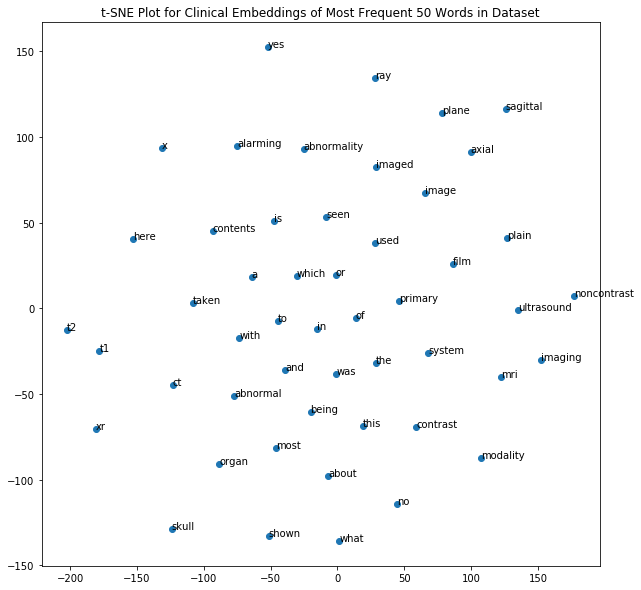

In [59]:
# tsne plot for the 50 most common words in vocab

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
vectors = [embedding[word] for word in vocab[:50]]
words = [word for word in vocab[:50]]
Y = tsne.fit_transform(vectors)


dims=(10,10)
fig, ax = plt.subplots(figsize=dims)
ax = plt.scatter(Y[:,0], Y[:,1])
plt.title("t-SNE Plot for Clinical Embeddings of Most Frequent 50 Words in Dataset")

for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()


### Getting cosine-similarities of pair wise sentences/averaged categories

In [79]:
# utility functions to get average sentence/category embeddings or cosine similarities


def get_average_sentence_embedding(s):
    average = np.zeros(200)
    for word in s:
        average += embedding[word]
    return average/len(s)

def get_category_average(cat, q_a):
    average = np.zeros(200)
    for s in cat[q_a]:
        average += get_average_sentence_embedding(s)
    return average/len(cat[q_a])
        
# print (get_average_sentence_embedding(['what', 'is', 'mri'], embedding))

def sentence_pair_cosine_similarity(s1, s2):
    s1 = get_average_sentence_embedding(s1)
    s2 = get_average_sentence_embedding(s2)  
    return float(cs(s1.reshape(1,-1),s2.reshape(1,-1)))
          
# can be improved to n*(n-1)/2 compairsons instead of n*n if cat1 == cat2   
def category_pairwise_cosine(cat1, cat2, q_a):
    average = 0
#     start = time.time()
    for s1 in cat1[q_a][:100]:
        for s2 in cat2[q_a][:100]:
            average += sentence_pair_cosine_similarity(s1, s2)
#     print (time.time()-start) 
    return average/10000

# averaged embedding value for Q or A in a category
df_q_average_emb = pd.DataFrame()
df_a_average_emb = pd.DataFrame()
for cat in categories:
    df_q_average_emb[cat.Name] = get_category_average(cat, "Q_parsed") 
    df_a_average_emb[cat.Name] = get_category_average(cat, "A_parsed")print (model.similarity('fracture', 'osteoporosis'))

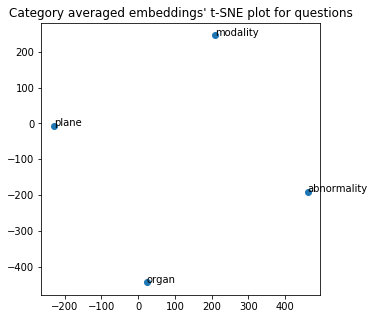

In [87]:
tsne = TSNE(n_components=2, random_state=0)
vectors = [df_q_average_emb[cat] for cat in df_q_average_emb if (cat != "all")]
Y = tsne.fit_transform(vectors)
words = [cat.Name for cat in categories if (cat.Name != "all")]
# print (vectors)
dims=(5,5)
fig, ax = plt.subplots(figsize=dims)
ax = plt.scatter(Y[:,0], Y[:,1])
plt.title("Category averaged embeddings' t-SNE plot for questions")

for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()


In [198]:
# sentence pair cosine similarity averaged over a category
# took too much time so restricted to 100 examples select 100 examples pairs over the 4 categories
pair_cs = {}
import time
start = time.time()
for cat1 in categories:
    cat1_dict = {}
    if (cat1.Name == "all"): continue
    for cat2 in categories:
        if (cat2.Name == cat1.Name or cat2.Name == "all"): continue
        cat1_dict[cat2.Name] = category_pairwise_cosine(cat1, cat2, "Q_parsed") 
    pair_cs[cat1.Name] = cat1_dict
    print ("time elapsed\n", time.time()-start)

time elapsed
 7.585910797119141
time elapsed
 14.417811870574951
time elapsed
 21.422752857208252
time elapsed
 28.49594521522522


In [199]:
print (
'''For every question in each category, cosine similarity is calculated with 100 examples from other categories 
and average is reported:\n''')
print (pair_cs)

For every question in each category, cosine similarity is calculated with 100 examples from other categories 
and average is reported:

{'modality': {'plane': 0.6606435769220095, 'organ': 0.6262710018705349, 'abnormality': 0.6795675234488365}, 'plane': {'modality': 0.6606435769220105, 'organ': 0.6680668379365231, 'abnormality': 0.7220945183562739}, 'organ': {'modality': 0.626271001870536, 'plane': 0.6680668379365258, 'abnormality': 0.7022904848113051}, 'abnormality': {'modality': 0.6795675234488423, 'plane': 0.7220945183562729, 'organ': 0.7022904848113108}}


# Question Classification on the basis of Cosine Similarity of Clinical Embeddings 

In [200]:
def question_classification_model(sentence):

    similarity_scores = {}
    maximum_score = -1
    start = time.time()
    for cat in categories:
        if (cat.Name == "all"): continue
        sim_score = 0
        length = len(cat['Q'].unique()) 
        for key, item in cat.groupby('Q'):
            if sentence == key: continue
            sim_score += sentence_pair_cosine_similarity(_parse_sentence(sentence), _parse_sentence(key))
        sim_score/=length 
        similarity_scores[cat.Name] = sim_score
        if sim_score > maximum_score:
            maximum_score = sim_score
            predicted_category = cat.Name


    return predicted_category

In [201]:
# testing question classification model on questions as they occur in the dataset (i.e only 35% are unique questions)
# function needs changes for this block to work
# correct = 0
# total = 0
# start = time.time()
# for cat in categories:
#     if (cat.Name == "all"): continue
#     print ("time elapsed\t",start - time.time())
#     for s in cat["Q_parsed"][2000:2100]:
#         total+=1
# #         print (s)
#         if (question_classification_model(s) == cat.Name): correct+=1

# accuracy = correct / total

# print (accuracy)

In [202]:
# running on the total 247 unique q/a's

correct = 0
total = 0
start = time.time()
for cat in categories:
    if (cat.Name == "all"): continue
    print ("time elapsed\t",time.time() - start)
    for key, item in cat.groupby('Q'):
        total+=1
#         print (key)
#         print (_parse_sentence(key))
        ans = question_classification_model((key))
        if ans == cat.Name: 
            correct+=1
#             print ("correct : " , ans)
#         else: print ("Incorrect : " , ans)

accuracy = correct / total

# print (accuracy, correct, total)

time elapsed	 0.0
time elapsed	 6.065136671066284
time elapsed	 16.12637162208557
time elapsed	 25.761584997177124


### Accuracy

In [203]:
print (accuracy, correct, total)

0.7975708502024291 197 247


### Cosine Similiarities for Clinical Embeddings

In [204]:
cosine_clinical_list_questions = []
for cat1 in categories[1:]:
    lst = []
    for cat2 in categories[1:]:
        val = float(cs(df_q_average_emb[cat1.Name].to_numpy().reshape(1,-1),df_q_average_emb[cat2.Name].to_numpy().reshape(1,-1),dense_output=True))
        lst.append(val)
    cosine_clinical_list_questions.append(lst)
                                  
cosine_clinical_list_answers = []
for cat1 in categories[1:]:
    lst = []
    for cat2 in categories[1:]:
        val = float(cs(df_a_average_emb[cat1.Name].to_numpy().reshape(1,-1),df_a_average_emb[cat2.Name].to_numpy().reshape(1,-1)))
        lst.append(val)
    cosine_clinical_list_answers.append(lst)
                          
# to rename index/columns of dataframes
rename = {}
i = 0 
for cat in categories[1:]:
    rename[i] = cat.Name
    i+=1

# converting cosine similarity arrays to dataframes for easier plotting through seaborn
cosine_clinical_q_dataframe = pd.DataFrame(cosine_clinical_list_questions)
cosine_clinical_q_dataframe.rename(columns=rename, index=rename, inplace=True)
 
cosine_clinical_a_dataframe = pd.DataFrame(cosine_clinical_list_answers)
cosine_clinical_a_dataframe.rename(columns=rename, index=rename, inplace=True)

print (cosine_clinical_q_dataframe,"\n")
print (cosine_clinical_a_dataframe)

             modality     plane     organ  abnormality
modality     1.000000  0.870050  0.832858     0.873641
plane        0.870050  1.000000  0.831650     0.866216
organ        0.832858  0.831650  1.000000     0.870738
abnormality  0.873641  0.866216  0.870738     1.000000 

             modality     plane     organ  abnormality
modality     1.000000  0.301657  0.166683     0.238583
plane        0.301657  1.000000  0.331651     0.313866
organ        0.166683  0.331651  1.000000     0.602915
abnormality  0.238583  0.313866  0.602915     1.000000


In [205]:
# function plot the cosine similarities for questions and answers

def plot_cosine_similarities(data, title):
    ax = sns.scatterplot(data=data)
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)

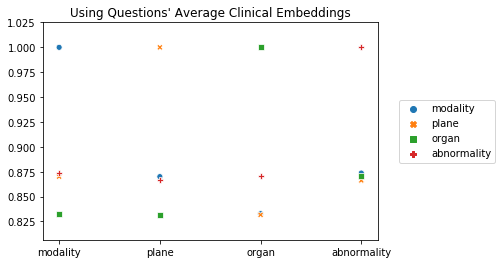

In [206]:
plot_cosine_similarities(cosine_clinical_q_dataframe, "Using Questions' Average Clinical Embeddings")

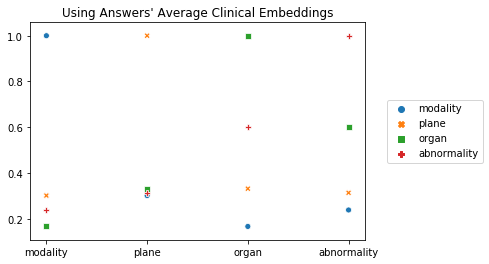

In [207]:
plot_cosine_similarities(cosine_clinical_a_dataframe, "Using Answers' Average Clinical Embeddings")

### Using One-Hot Embeddings (instead of pretrained clinical embeddings) 

In [208]:
# utility functions for generating one-hot-vectors and their averages
# TODO : change the hard-coded vocab size to automatic

# one - hot vector encoding for a sentence
def generate_onehotvector(s):
    encoding = []
    for id in s:
        num = np.zeros(2107)
        num[id] = 1
        encoding.append(num)
    return encoding

# returns array with 1 at each id in sentence
def generate_sentencevector(s):
    num = np.zeros(2108)
    for id in s:
        num[id] = 1
    return num

# averages out all the one-hot-vectors of one series such as all questions/answers in one modality
def get_average_vector(df_input):
    average = np.zeros(2108)
    for v in df_input:
        average += generate_sentencevector(v)
    
    return average/len(df_input)

In [209]:
# checking the cosine similarity between average question/answer using manual one hot embeddings


# creating df with average sentence embedding values for all questions and answers category wise
df_q_average = pd.DataFrame()
df_a_average = pd.DataFrame()
for cat in categories[1:]:
    df_q_average[cat.Name] = get_average_vector(cat['Q_encoded']) 
    df_a_average[cat.Name] = get_average_vector(cat['A_encoded'])


# calculating the cosine similiarities
cs_q = []
for cat1 in categories[1:]:
    lst = []
    for cat2 in categories[1:]:
        val = float(cs(df_q_average[cat1.Name].to_numpy().reshape(1,-1),df_q_average[cat2.Name].to_numpy().reshape(1,-1),dense_output=True))
        lst.append(val)
    cs_q.append(lst)

cs_a = []
for cat1 in categories[1:]:
    lst = []
    for cat2 in categories[1:]:
        val = float(cs(df_a_average[cat1.Name].to_numpy().reshape(1,-1),df_a_average[cat2.Name].to_numpy().reshape(1,-1)))
        lst.append(val)
    cs_a.append(lst)
                          

# to rename index/columns of dataframes
rename = {}
i = 0 
for cat in categories[1:]:
    rename[i] = cat.Name
    i+=1

# converting cosine similarity arrays to dataframes
df_Q_cs = pd.DataFrame(cs_q)
df_Q_cs.rename(columns=rename, index=rename, inplace=True)
 
df_A_cs = pd.DataFrame(cs_a)
df_A_cs.rename(columns=rename, index=rename, inplace=True)

print (df_Q_cs,"\n")
print (df_A_cs)

             modality     plane     organ  abnormality
modality     1.000000  0.832394  0.793401     0.815185
plane        0.832394  1.000000  0.806350     0.851763
organ        0.793401  0.806350  1.000000     0.832993
abnormality  0.815185  0.851763  0.832993     1.000000 

             modality     plane     organ  abnormality
modality     1.000000  0.928719  0.868299     0.969018
plane        0.928719  1.000000  0.852327     0.950954
organ        0.868299  0.852327  1.000000     0.894867
abnormality  0.969018  0.950954  0.894867     1.000000


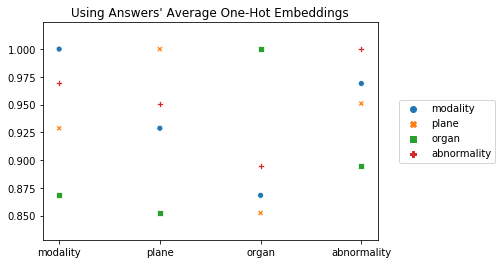

In [210]:
plot_cosine_similarities(df_A_cs, "Using Answers' Average One-Hot Embeddings")

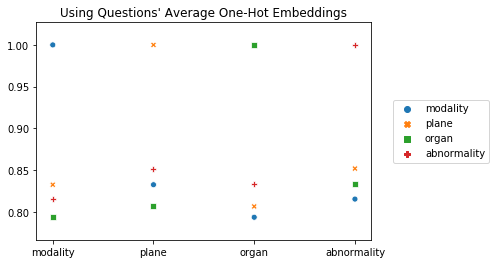

In [211]:
plot_cosine_similarities(df_Q_cs, "Using Questions' Average One-Hot Embeddings")